# Классификация новых музыкальных треков по жанрам в стриминговвом сервисе "МиФаСоль"

# 1. Описание проекта

Заказчик исследования - популярный музыкальный стриминговый сервис "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Сотрудники из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Наша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Основные этапы работы:

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

## Описание полей данных

* ***instance_id*** -Уникальный идентификатор трека
* ***track_name*** - Название трека
* ***acousticness*** - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим
* ***danceability*** - Танцевальность
* ***duration_ms*** - Продолжительность трека в миллисекундах
* ***energy*** - Энергия
* ***instrumentalness*** - Определяет, содержит ли трек вокал
* ***key*** - базовый ключ (нота) произведения
* ***liveness*** - Определяет присутствие аудитории в записи
* ***loudness*** - Общая громкость трека в децибелах (дБ)
* ***mode*** - Указывает на модальность (мажорную или минорную) трека
* ***speechiness*** - Речевой характер определяет наличие в треке разговорной речи
* ***tempo*** - Темп трека в ударах в минуту (BPM)
* ***obtained_date*** - дата загрузки в сервис
* ***valence*** - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком
* **music_genre** - Музыкальный жанр трека

# 2. Загрузка данных

In [39]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install phik
!pip install catboost
!pip install feature-engine
!pip install imbalanced-learn

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik

from catboost import CatBoostClassifier
from catboost.utils import get_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix,
                             f1_score,
                             precision_recall_curve,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             roc_curve,
                             accuracy_score,
                             classification_report)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler,
                                   OneHotEncoder, MinMaxScaler, LabelEncoder,
                                   RobustScaler, PolynomialFeatures)
from sklearn.neural_network import MLPClassifier
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample, shuffle

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import warnings

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
try:
    train = pd.read_csv('kaggle_music_genre_train.csv')
    test = pd.read_csv('kaggle_music_genre_test.csv')
except:
    train = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv')
    test = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_test.csv')

In [46]:
test = pd.read_csv('kaggle_music_genre_test.csv')

In [5]:
def get_data_info(data):
    display(data.info())
    display(data.head())
    display(data.isna().sum())
    display(data.describe().T)

In [6]:
get_data_info(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,"25,143.00",Highwayman,0.48,0.67,"182,653.00",0.35,0.02,D,0.12,-16.84,Major,0.05,101.38,4-Apr,0.45,Country
1,"26,091.00",Toes Across The Floor,0.24,0.45,"187,133.00",0.67,0.00,A,0.11,-8.39,Minor,0.04,113.07,4-Apr,0.54,Rock
2,"87,888.00",First Person on Earth,0.23,0.45,"173,448.00",0.80,0.00,E,0.18,-5.22,Minor,0.37,80.98,4-Apr,0.34,Alternative
3,"77,021.00",No Te Veo - Digital Single,0.06,0.85,"255,987.00",0.87,0.00,G#,0.33,-4.80,Minor,0.08,116.01,4-Apr,0.97,Hip-Hop
4,"20,852.00",Chasing Shadows,0.23,0.74,"195,333.00",0.57,0.00,C,0.18,-5.55,Major,0.05,76.49,4-Apr,0.58,Alternative


instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
instance_id,"20,394.00","55,973.85","20,695.79","20,011.00","38,157.25","56,030.00","73,912.75","91,758.00"
acousticness,"20,394.00",0.27,0.32,0.00,0.02,0.12,0.47,1.00
danceability,"20,394.00",0.56,0.17,0.06,0.45,0.57,0.68,0.98
duration_ms,"20,394.00","220,375.43","126,728.33",-1.00,"177,517.00","219,533.00","266,000.00","4,497,994.00"
energy,"20,394.00",0.63,0.25,0.00,0.47,0.67,0.83,1.00
instrumentalness,"20,394.00",0.16,0.31,0.00,0.00,0.00,0.08,1.00
liveness,"20,394.00",0.20,0.17,0.01,0.10,0.13,0.25,1.00
loudness,"20,394.00",-8.55,5.50,-44.41,-10.26,-7.05,-5.05,3.74
speechiness,"20,394.00",0.09,0.10,0.02,0.04,0.05,0.10,0.94
tempo,"19,952.00",120.94,30.43,34.77,95.92,120.01,141.97,220.04


In [7]:
get_data_info(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.30,0.76,"146,213.00",0.68,0.00,A#,0.30,-7.14,Minor,0.36,90.36,4-Apr,0.90
1,72394,The Hunter,0.54,0.26,"240,360.00",0.52,0.01,G#,0.08,-5.17,Major,0.03,78.39,4-Apr,0.32
2,88081,Hate Me Now,0.01,0.68,"284,000.00",0.77,0.00,A,0.11,-4.40,Minor,0.22,90.00,4-Apr,0.41
3,78331,Somebody Ain't You,0.02,0.59,"177,354.00",0.75,0.00,B,0.12,-4.60,Major,0.05,160.05,4-Apr,0.61
4,72636,Sour Mango,0.00,0.42,-1.00,0.45,0.01,D,0.04,-8.83,Major,0.20,73.83,4-Apr,0.12


instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
instance_id,"5,099.00","55,643.87","20,762.38","20,012.00","37,571.00","55,246.00","73,702.00","91,709.00"
acousticness,"5,099.00",0.28,0.32,0.00,0.02,0.12,0.46,1.00
danceability,"5,099.00",0.56,0.17,0.06,0.45,0.57,0.68,0.98
duration_ms,"5,099.00","217,397.41","115,637.41",-1.00,"173,733.50","217,500.00","264,247.00","1,360,027.00"
energy,"5,099.00",0.62,0.25,0.00,0.47,0.66,0.83,1.00
instrumentalness,"5,099.00",0.17,0.31,0.00,0.00,0.00,0.09,0.99
liveness,"5,099.00",0.20,0.17,0.02,0.10,0.13,0.25,0.99
loudness,"5,099.00",-8.63,5.62,-46.12,-10.23,-7.13,-5.13,1.95
speechiness,"5,099.00",0.09,0.10,0.02,0.04,0.05,0.10,0.92
tempo,"4,978.00",121.25,29.88,37.11,96.07,120.05,141.93,216.03


Предварительно можем отметить наличие пропусков в столбцах ***key***, ***mode*** и ***tempo*** в обоих датафреймах.

# 3. Предобработка данных

Для начала избавимся от столбцов, которые не сыграют роли в дальнейшем обучении моделей (в нашем случае это **instance_id**, **track_name** и **obtained_date**).

In [8]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

Проверим наличие полных дубликатов:

In [9]:
train.duplicated().sum()

7

Избавимся от дубликатов в данных:

In [10]:
train = train.drop_duplicates()
train.duplicated().sum()

0

# 4. Исследовательский анализ данных

В датасете чуть более 20000 строк. Однако некоторые колонки имеют пропуски.  
К количественным признакам относятся столбцы:
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* liveness - привлекательность
* loudness - громкость
* speechiness - выразительность
* tempo - темп
* valence - привлекательность произведения для пользователей сервиса


К категориальным с признакам относятся столбцы:
* track_name - название трека  
* key - базовый ключ (нота) произведения
* mode - указывает на модальность (мажорную или минорную) трека
* obtained_date - дата загрузки в сервис


Целевое признак находится в столбце music_genre (музыкальный жанр)

Построим матрицу корреляции и посмотрим на взаимосвязь признаков.

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


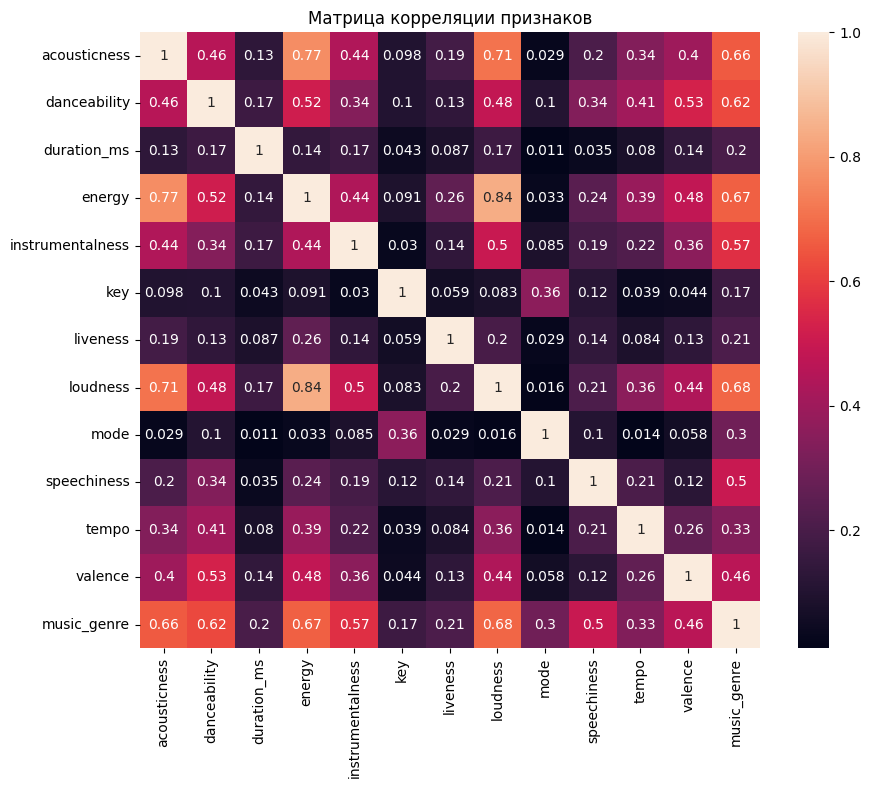

In [11]:
phik_overview = train.phik_matrix()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(phik_overview, annot=True)
plt.title('Матрица корреляции признаков')
plt.show()

In [12]:
phik_target = phik_overview['music_genre'].sort_values(ascending=False)
phik_target

music_genre        1.00
loudness           0.68
energy             0.67
acousticness       0.66
danceability       0.62
instrumentalness   0.57
speechiness        0.50
valence            0.46
tempo              0.33
mode               0.30
liveness           0.21
duration_ms        0.20
key                0.17
Name: music_genre, dtype: float64

Можем выявить наибольшую взаимосвязь с целевым признаком у следующих фичей: **loudness**, **energy**, **acousticness** и **danceability**.

# 5. Изучение дисбаланса классов

In [14]:
share_of_genre = train['music_genre'].value_counts(normalize = True)
share_of_genre

Blues         0.14
Alternative   0.13
Electronic    0.13
Rap           0.12
Rock          0.11
Country       0.10
Anime         0.09
Classical     0.07
Jazz          0.06
Hip-Hop       0.06
Name: music_genre, dtype: float64

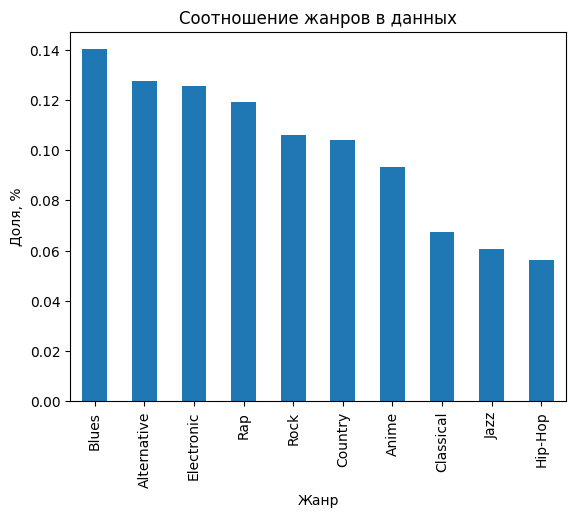

In [15]:
share_of_genre.plot(kind='bar')
plt.title('Соотношение жанров в данных')
plt.xlabel('Жанр')
plt.ylabel('Доля, %')
plt.show()

Наблюдаем дисабаланс среди жанров. Уделим внимение этому фактору при обучении моделей.

# 6. Подготовка данных к обучению

In [16]:
X = train.drop('music_genre', axis=1)
y = train['music_genre']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [18]:
num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=123)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

In [19]:
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [20]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

# 7. Логистическая регрессия

In [21]:
model_lr = LogisticRegression(class_weight='balanced', random_state=123)

pipeline_lr = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model_lr)
])

param_dist_lr = {
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga']
}

grid_lr = RandomizedSearchCV(pipeline_lr,
                    param_dist_lr,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=123,
                    scoring='f1_micro',
                    n_jobs=-1)

In [22]:
grid_lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('impute',
                                                                                                IterativeImputer(random_state=123)),
                                                                                               ('scale',
                                                                                                RobustScaler()),
                                                                                               ('drop_correlated_features',
                                                                                                DropCorrelatedFeatures()),
                                                                                               ('polynomial_features',
                                                                                                PolynomialFeatures()),
                                                                                               ('drop_constant_features',
                                                                                                Dro...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encode',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['key',
                                                                                'mode'])])),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=123))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__penalty': ['l1', 'l2'],
                                        'model__solver': ['liblinear', 'saga']},
                   random_state=123, scoring='f1_micro', verbose=5)

In [23]:
grid_lr.best_params_

{'model__solver': 'liblinear', 'model__penalty': 'l1'}

In [24]:
predicted_lr = grid_lr.predict(X_valid)
f1_score(y_valid, predicted_lr, average='micro').round(2)

0.43

Показатель F1-меры для логистичсекой регрессии - 0.43

Лучшие параметры - **solver**: 'liblinear', **penalty**: 'l2'

# 8. Случайный лес

In [25]:
model_rfc = RandomForestClassifier(class_weight='balanced', random_state=123)

pipeline_rfc = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model_rfc)
])

param_dist_rfc = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [1, 5, 10]
}

grid_rfc = RandomizedSearchCV(pipeline_rfc,
                    param_dist_rfc,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=123,
                    scoring='f1_micro',
                    n_jobs=-1)

In [26]:
grid_rfc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_trans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('impute',
                                                                                                IterativeImputer(random_state=123)),
                                                                                               ('scale',
                                                                                                RobustScaler()),
                                                                                               ('drop_correlated_features',
                                                                                                DropCorrelatedFeatures()),
                                                                                               ('polynomial_features',
                                                                                                PolynomialFeatures()),
                                                                                               ('drop_constant_features',
                                                                                                Dro...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encode',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['key',
                                                                                'mode'])])),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=123))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__max_depth': [1, 5, 10],
                                        'model__n_estimators': [100, 200, 300]},
                   random_state=123, scoring='f1_micro', verbose=5)

In [27]:
grid_rfc.best_params_

{'model__n_estimators': 300, 'model__max_depth': 10}

In [28]:
predicted_rfc = grid_lr.predict(X_valid)
f1_score(y_valid, predicted_rfc, average='micro').round(2)

0.43

Показатель F1-меры для случайного леса - 0.43

Лучшие параметры - **n_estimators**: '300', **max_dept**: '10'

# 9. MLPClassifier

In [40]:
mlpc = MLPClassifier()

pipeline_mlpc = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', mlpc)
])

param_dist_mlpc = {
    'model__hidden_layer_sizes': [(100,), (200,), (300,)],
    'model__activation': ['relu', 'tanh', 'logistic'],
    'model__alpha': [0.0001, 0.001, 0.01]
}

grid_mlpc = RandomizedSearchCV(pipeline_mlpc,
                    param_dist_mlpc,
                    n_iter=30,
                    cv=5,
                    verbose=5,
                    random_state=123,
                    scoring='f1_micro',
                    n_jobs=-1)

In [41]:
grid_mlpc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 27 is smaller than n_iter=30. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('impute',
                                                                                                IterativeImputer(random_state=123)),
                                                                                               ('scale',
                                                                                                RobustScaler()),
                                                                                               ('drop_correlated_features',
                                                                                                DropCorrelatedFeatures()),
                                                                                               ('polynomial_features',
                                                                                                PolynomialFeatures()),
                                                                                               ('drop_constant_features',
                                                                                                Drop...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encode',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['key',
                                                                                'mode'])])),
                                             ('model', MLPClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__activation': ['relu', 'tanh',
                                                              'logistic'],
                                        'model__alpha': [0.0001, 0.001, 0.01],
                                        'model__hidden_layer_sizes': [(100,),
                                                                      (200,),
                                                                      (300,)]},
                   random_state=123, scoring='f1_micro', verbose=5)

In [42]:
grid_mlpc.best_params_

{'model__hidden_layer_sizes': (100,),
 'model__alpha': 0.01,
 'model__activation': 'logistic'}

In [43]:
predicted_mlpc = grid_mlpc.predict(X_valid)
f1_score(y_valid, predicted_mlpc, average='micro').round(2)

0.46

Показатель F1-меры для MLPClassifier - 0.46

Лучшие параметры - **hidden_layer_sizes**: '100,', **alpha**: '0.01', **activation**: 'logistic'

# 10. Предсказания на тестовых данных

In [47]:
test_1 = test

In [48]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [49]:
features = train.drop('music_genre', axis=1)
target = train['music_genre']

In [53]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),
                    alpha=0.01,
                    activation='logistic')

mlpc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', mlpc)
])

In [55]:
pipeline_mlpc.fit(features, target)
pred = pipeline_mlpc.predict(test)

pred = pred.ravel().tolist()
# Создание столбца с предсказаниями
pred_series = pd.Series(pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = test_1['instance_id']

# Создание DataFrame из столбцов
prediction = pd.concat([instance_id_column, pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
prediction.to_csv('predict.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 11. Выводы

Провели предобработку данных, проверили данные на мультиколлинеарность с помощью матрицы корреляции. Подготовили данные с помощью инструмента pipeline.

По итогу выбрали для предсказаний модель MLPClassifier, так как у неё оказался самый большой показатель на тренировочной выборке по F1-метрике:

* LogisticRegression - 0.43
* RandomForestClassifier - 0.43
* MLPClassifier - 0.46